In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import deque

class EpisodicReplayMemory(object):
    def __init__(self, capacity, max_episode_length):
        self.num_episodes = capacity // max_episode_length
        self.buffer = deque(maxlen=self.num_episodes)
        self.buffer.append([])
        self.position = 0
        
    def push(self, state, action, reward, policy, mask, done):
        self.buffer[self.position].append((state, action, reward, policy, mask))
        if done:
            self.buffer.append([])
            self.position = min(self.position + 1, self.num_episodes - 1)
            
    def sample(self, batch_size, max_len=None):
        min_len = 0
        while min_len == 0:
            rand_episodes = random.sample(self.buffer, batch_size)
            min_len = min(len(episode) for episode in rand_episodes)
            
        if max_len:
            max_len = min(max_len, min_len)
        else:
            max_len = min_len
            
        episodes = []
        for episode in rand_episodes:
            if len(episode) > max_len:
                rand_idx = random.randint(0, len(episode) - max_len)
            else:
                rand_idx = 0

            episodes.append(episode[rand_idx:rand_idx+max_len])
            
        return list(map(list, zip(*episodes)))
    
    def __len__(self):
        return int(len(self.buffer))

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size=256):
        super(ActorCritic, self).__init__()
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=1)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_actions)
        )
        
        
    def forward(self, x):
        policy  = self.actor(x).clamp(max=1-1e-20)
        q_value = self.critic(x)
        value   = (policy * q_value).sum(-1, keepdim=True)
        return policy, q_value, value

In [5]:
def test_env(render=False):
    state = env.reset()
    done = False
    total_reward = 0
    if render: 
        env.render()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        policy, _, _ = model(state)
        action = policy.multinomial(1)
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        total_reward += reward
        if render: 
            env.render()
    return total_reward

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.subplot(132)
    plt.show()

In [6]:
def compute_acer_loss(policies, q_values, values, actions, rewards, retrace, masks, behavior_policies, gamma=0.99, truncation_clip=10, entropy_weight=0.0001):
    loss = 0
    
    for step in reversed(range(len(rewards))):
        importance_weight = policies[step].detach() / behavior_policies[step].detach()

        retrace = rewards[step] + gamma * retrace * masks[step]
        advantage = retrace - values[step]

        log_policy_action = policies[step].gather(1, actions[step]).log()
        truncated_importance_weight = importance_weight.gather(1, actions[step]).clamp(max=truncation_clip)
        actor_loss = -(truncated_importance_weight * log_policy_action * advantage.detach()).mean(0)

        correction_weight = (1 - truncation_clip / importance_weight).clamp(min=0)
        actor_loss -= (correction_weight * policies[step].log() * (q_values[step] - values[step]).detach()).sum(1).mean(0)
        
        entropy = entropy_weight * -(policies[step].log() * policies[step]).sum(1).mean(0)

        q_value = q_values[step].gather(1, actions[step])
        critic_loss = ((retrace - q_value) ** 2 / 2).mean(0)

        truncated_rho = importance_weight.gather(1, actions[step]).clamp(max=1)
        retrace = truncated_rho * (retrace - q_value.detach()) + values[step].detach()
        
        loss += actor_loss + critic_loss - entropy
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [7]:
def off_policy_update(batch_size, replay_ratio=4):
    if batch_size > len(replay_buffer) + 1:
        return
    
    for _ in range(np.random.poisson(replay_ratio)):
        trajs = replay_buffer.sample(batch_size)
        state, action, reward, old_policy, mask = map(torch.stack, zip(*(map(torch.cat, zip(*traj)) for traj in trajs)))

        q_values = []
        values   = []
        policies = []

        for step in range(state.size(0)):
            policy, q_value, value = model(state[step])
            q_values.append(q_value)
            policies.append(policy)
            values.append(value)

        _, _, retrace = model(state[-1])
        retrace = retrace.detach()
        compute_acer_loss(policies, q_values, values, action, reward, retrace, mask, old_policy)

In [8]:
env = gym.make("CartPole-v0")
model = ActorCritic(env.observation_space.shape[0], env.action_space.n)

optimizer = optim.Adam(model.parameters())

capacity = 1000000
max_episode_length = 200
replay_buffer = EpisodicReplayMemory(capacity, max_episode_length)

c:\users\박정은\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


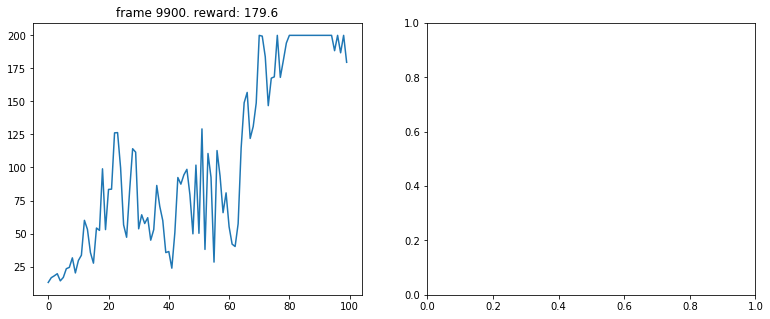

In [9]:
frame_idx    = 0
max_frames   = 10000
num_steps    = 5
log_interval = 100
test_rewards = []
state = env.reset()

while frame_idx < max_frames:
    
    q_values = []
    values   = []
    policies = []
    actions  = []
    rewards  = []
    masks    = []
    
    for step in range(num_steps):
    
        state = torch.FloatTensor(state).unsqueeze(0)
        policy, q_value, value = model(state)
        
        action = policy.multinomial(1)
        next_state, reward, done, _ = env.step(action.item())
        
        reward = torch.FloatTensor([reward]).unsqueeze(1)
        mask   = torch.FloatTensor(1 - np.float32([done])).unsqueeze(1)
        replay_buffer.push(state.detach(), action, reward, policy.detach(), mask, done)

        q_values.append(q_value)
        policies.append(policy)
        actions.append(action)
        rewards.append(reward)
        values.append(value)
        masks.append(mask)
        
        state = next_state
        if done:
            state = env.reset()
    


    
    next_state = torch.FloatTensor(state).unsqueeze(0)
    _, _, retrace = model(next_state)
    retrace = retrace.detach()
    compute_acer_loss(policies, q_values, values, actions, rewards, retrace, masks, policies)
    if len(replay_buffer.buffer)>128:
        off_policy_update(128)
    
    if frame_idx % log_interval == 0:
        test_rewards.append(np.mean([test_env() for _ in range(5)]))
        plot(frame_idx, test_rewards)
        
    frame_idx += num_steps

In [10]:
test_env(True)

200.0